# Exercise 1
## Baseband and Band-Pass Signals
### Problem 1
Generate a baseband signal and mix it directly to a band-pass region, and back!
Only use *real* operations for the mixing process.

This imports but a few common Python libraries

In [1]:
# import packages for scientific python and plotting
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline
YOUR_CODE_HERE = None  # placeholder

#### a) Generate a circularly normal distributed (complex) baseband signals with parameters as given!

In [2]:
fs = 10000  # sampling rate (samples per second)
signal_bandwidth = 1000  # two-sided bandwidth in Hz
len_signal = 10000  # in samples
mean_s = 0  # mean of the random signal
var_s = 1  # variance of the random signal

random_signal = YOUR_CODE_HERE  # generate white noise using numpy.random.randn
cutoff_freq = YOUR_CODE_HERE  # define the cutoff frequency to limit the spectral content to the signal bandwidth
#h_LP0 = sig.firwin(numtaps=51, cutoff=cutoff_freq, window='hamming', pass_zero=True, scale=True, nyq=0.5)
s_BB = YOUR_CODE_HERE  # create the baseband signal by filtering the noise

# solution
random_signal = 1/np.sqrt(2)*(np.random.randn(len_signal)*np.sqrt(var_s) + mean_s + 1j * (np.random.randn(len_signal)*np.sqrt(var_s) + mean_s))
cutoff_freq = signal_bandwidth/2
h_LP0 = sig.firwin(numtaps=51, cutoff=cutoff_freq, window='hamming', pass_zero=True, scale=True, fs=fs)

#cutoff_freq = signal_bandwidth/2/fs
#h_LP0 = sig.firwin(numtaps=51, cutoff=cutoff_freq, window='hamming', pass_zero=True, scale=True, nyq=0.5)
s_BB = np.convolve(h_LP0, random_signal, mode='same')
#end solution

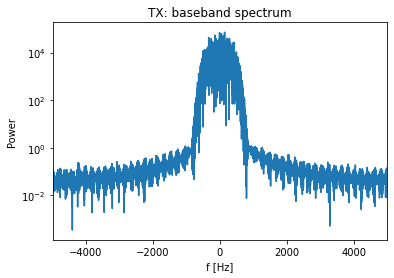

In [3]:
# plot baseband spectrum
f = np.arange(start=-fs/2, stop=fs/2, step=fs/len(s_BB))
tx_bb_spectrum = np.abs(np.fft.fftshift(np.fft.fft(s_BB)))**2
plt.semilogy(f, tx_bb_spectrum)
plt.xlim(-fs/2, fs/2); plt.xlabel("f [Hz]"); plt.ylabel('Power')
plt.title("TX: baseband spectrum");

#### b) Implement the quadrature upconverter!

In [4]:
fc = 2000  # carrier frequency

cosine = YOUR_CODE_HERE
sine = YOUR_CODE_HERE
s_BP = YOUR_CODE_HERE

# solution
x = s_BB.real
y = s_BB.imag
t = np.arange(len_signal) / fs
cosine = np.cos(2 * np.pi * fc * t)
sine = np.sin(2 * np.pi * fc * t)
s_BP = np.sqrt(2) * x * cosine - np.sqrt(2) * y * sine
# end solution

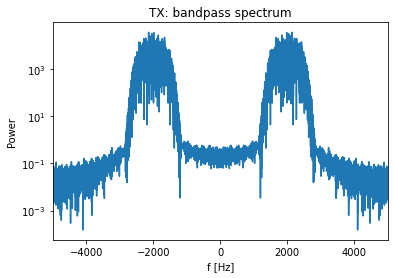

In [5]:
# plot bandpass spectrum
f = np.arange(start=-fs/2, stop=fs/2, step=fs/len(s_BP))
tx_bp_spectrum = np.abs(np.fft.fftshift(np.fft.fft(s_BP)))**2
plt.semilogy(f, tx_bp_spectrum)
plt.xlim(-fs/2, fs/2); plt.xlabel("f [Hz]"); plt.ylabel('Power')
plt.title("TX: bandpass spectrum");

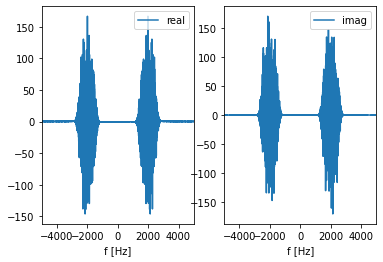

In [6]:
bp_spec = np.fft.fftshift(np.fft.fft(s_BP))
plt.subplot(121)
plt.plot(f, np.real(bp_spec),label='real')
plt.legend(loc=1)
plt.xlim(-fs/2, fs/2); plt.xlabel("f [Hz]");
plt.subplot(122)
plt.plot(f, np.imag(bp_spec), label='imag')
plt.legend(loc=1)
plt.xlim(-fs/2, fs/2); plt.xlabel("f [Hz]");

#### c) Translate the real-valued band-pass signal back to baseband! Pay attention to the correct application of a low-pass filter.

In [7]:
r_BP = s_BP  # noise-free, ideal channel
h_LP1 = sig.firwin(numtaps=51, cutoff=signal_bandwidth/fs/2, window='hamming', pass_zero=True, scale=True, nyq=0.5)
x = np.sqrt(2) * r_BP * cosine
x = np.convolve(h_LP1, x, 'same')

y = np.sqrt(2) * r_BP * sine
y = np.convolve(h_LP1, y, 'same')
r_BB = x + 1j * y

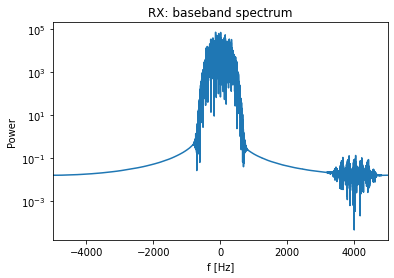

In [8]:
# plot received baseband spectrum
f = np.arange(start=-fs/2, stop=fs/2, step=fs/len(r_BB))
rx_bb_spectrum = np.abs(np.fft.fftshift(np.fft.fft(r_BB)))**2
plt.semilogy(f, rx_bb_spectrum)
plt.xlim(-fs/2, fs/2); plt.xlabel("f [Hz]"); plt.ylabel('Power')
plt.title("RX: baseband spectrum");

### Comprehension

Use `fs=10000` Hz and `fc=2000` Hz.

1. What's the reason for the artifact at `f=-0.4*fs` and why isn't it at `f=0.4*fs`?
2. If the receiver uses `sin(x)` instead of `-sin(x)` the artifact changes location. Explain!
3. What to you need to consider when choosing the cut-off frequency of the low-pass filter in the receiver in order to suppress distorting signal components?
4. How do you modify the simulation in order to allow for arbitrarily high carrier frequencies?
5. How do real world systems solve this issue and are able to mix independently from the sampling frequency?

# Solution

1. The quadrature downconverter implements a multiplication with a complex exponential (complex sinusoid), which shifts the upper part of the spectrum to 0 Hz, and the lower part by -2000 Hz to -4000 Hz
2. The negative sign changes direction of the mixing, thus mixing fc to 0 and -fc to -2*fc.
3. The filter should (of course) suppress the components at +-2*fc, but generally all frequencies outside the band of interest (as far as feasible).
4. The highest representable frequency is at fs/2 (Nyquist). Thus, for arbitrarily high carrier frequencies you'd have to implement arbitrarily high sampling rates. (Or is it? Just our plotting in frequency domain is limited to the nyquist zone, both spectrum and time signal are assumed to be periodic -> Increase sampling frequency with rising bandwidth) 
5. We can use multiple mixers and combine the quadrature upconverter with analog mixers. We mix digitally to a fixed IF (intermediate frequency) and can mix further after digital to analog conversion.